# Fondamenti di Quantizzazione con Hugging Face

## Lezione 1: Cos'è la auantizzazione e perché è importante?

### Motivazione

La quantizzazione è il processo di conversione dei pesi e delle attivazioni del modello da alta precisione (ad esempio FP32) a formati a precisione ridotta (ad esempio INT8).

#### Perché Quantizzare?
- Riduzione dei requisiti di memoria e di calcolo
- Permette di eseguire modelli di grandi dimensioni su dispositivi edge o macchine locali
- Degradazione delle prestazioni minima se eseguita correttamente

### Il Problema
- **Le dimensioni dei modelli continuano ad aumentare** — il paper SmoothQuant del 2022 (Fig. 1) mostra il gap tra la dimensione del modello e l'aumento della memoria degli acceleratori. [Leggi il paper](https://arxiv.org/abs/2211.10438)

- Nel periodo 2023–2024, i modelli di linguaggio di grandi dimensioni (LLM) comunemente usati variano molto in termini di dimensioni:
  - GPT-3 (175 miliardi di parametri)
  - MT-NLG (530 miliardi di parametri, non 70 miliardi)
  - LLaMA-2-13B, 34B, ecc.

> 📉 Obiettivo: **Rendere i modelli accessibili** tramite compressione del modello

Tipi di compressione del modello:
- **Pruning** (non trattato in questo corso)
- **Knowledge Distillation** (non trattata in questo corso)
- **Quantizzazione** (focus di questo corso)

> Per un approfondimento sulle tecniche di compressione dei modelli, inclusi pruning e knowledge distillation, è disponibile online il corso del MIT: [https://hanlab.mit.edu/courses/2024-fall-65940]


## Lezione 2: Tipi di Dati & Quantizzazione Lineare

Installa e importa le dipendenze.


In [1]:
# Versione di torch consigliata per questo corso
#!pip install torch==2.1.1
#!pip install matplotlib
#!pip install numpy


In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np

### Comprensione dei Tipi di Dati

#### Interi (Non firmati e Firmati)
Nel deep learning e nel calcolo numerico, scegliere il tipo di dato appropriato è fondamentale per bilanciare precisione e efficienza di calcolo. Ecco i tipi di interi più comuni in PyTorch:

- **`torch.uint8`** (intero unsigned a 8 bit): valori da **0 a 255**
- **`torch.int8`** (intero signed a 8 bit): valori da **-128 a 127**
- **`torch.int16`** (intero signed a 16 bit): valori da **-32.768 a 32.767**
- **`torch.int32`** (intero signed a 32 bit): valori da **-2.147.483.648 a 2.147.483.647**
- **`torch.int64`** (intero signed a 64 bit): valori da **-9.2e18 a 9.2e18**


In [3]:
print("int8: ", torch.iinfo(torch.int8))
print("int16:", torch.iinfo(torch.int16))
print("int32:", torch.iinfo(torch.int32))
print("int64:", torch.iinfo(torch.int64))

int8:  iinfo(min=-128, max=127, dtype=int8)
int16: iinfo(min=-32768, max=32767, dtype=int16)
int32: iinfo(min=-2.14748e+09, max=2.14748e+09, dtype=int32)
int64: iinfo(min=-9.22337e+18, max=9.22337e+18, dtype=int64)


### Rappresentazione in Virgola Mobile

Ogni numero in virgola mobile ha:
- **Segno (1 bit)**: determina se è positivo o negativo
- **Esponente**: controlla l'intervallo dei valori rappresentabili
- **Frazione (Mantissa)**: controlla la precisione

#### Formati FP e Struttura
- **FP32**: 1 bit di segno, 8 bit di esponente, 23 bit di frazione → standard per l'addestramento
- **FP16**: 1 bit di segno, 5 bit di esponente, 10 bit di frazione → utilizzato nella precisione mista
- **BF16**: 1 bit di segno, 8 bit di esponente, 7 bit di frazione → intervallo più ampio, meno precisione rispetto a FP16


In [4]:
# Mostra le informazioni sui numeri in virgola mobile: precisione, valori minimi/massimi per ogni tipo
print("torch.float64 (doppia precisione):")
print(torch.finfo(torch.float64))
print("\ntorch.float32 (precisione singola):")
print(torch.finfo(torch.float32))
print("\ntorch.float16 (mezza precisione):")
print(torch.finfo(torch.float16))
print("\ntorch.bfloat16 (virgola mobile BF16):")
print(torch.finfo(torch.bfloat16))


torch.float64 (doppia precisione):
finfo(resolution=1e-15, min=-1.79769e+308, max=1.79769e+308, eps=2.22045e-16, smallest_normal=2.22507e-308, tiny=2.22507e-308, dtype=float64)

torch.float32 (precisione singola):
finfo(resolution=1e-06, min=-3.40282e+38, max=3.40282e+38, eps=1.19209e-07, smallest_normal=1.17549e-38, tiny=1.17549e-38, dtype=float32)

torch.float16 (mezza precisione):
finfo(resolution=0.001, min=-65504, max=65504, eps=0.000976562, smallest_normal=6.10352e-05, tiny=6.10352e-05, dtype=float16)

torch.bfloat16 (virgola mobile BF16):
finfo(resolution=0.01, min=-3.38953e+38, max=3.38953e+38, eps=0.0078125, smallest_normal=1.17549e-38, tiny=1.17549e-38, dtype=bfloat16)


Questo output mostra, per ogni tipo di dato:
- **Precisione**: quanto finemente i valori possono essere distinti
- **Valori minimo e massimo**: l'intervallo di numeri che questo tipo può rappresentare
- **Epsilon (`eps`)**: il numero positivo più piccolo tale che `1.0 + eps != 1.0` — una misura della precisione numerica

Questo aiuta a comprendere i compromessi tra precisione e intervallo nei vari tipi in virgola mobile.


### Infografica: Struttura del Formato in Virgola Mobile

Per comprendere la struttura dei vari tipi in virgola mobile, ecco un confronto visivo di come è distribuita la larghezza totale in bit:


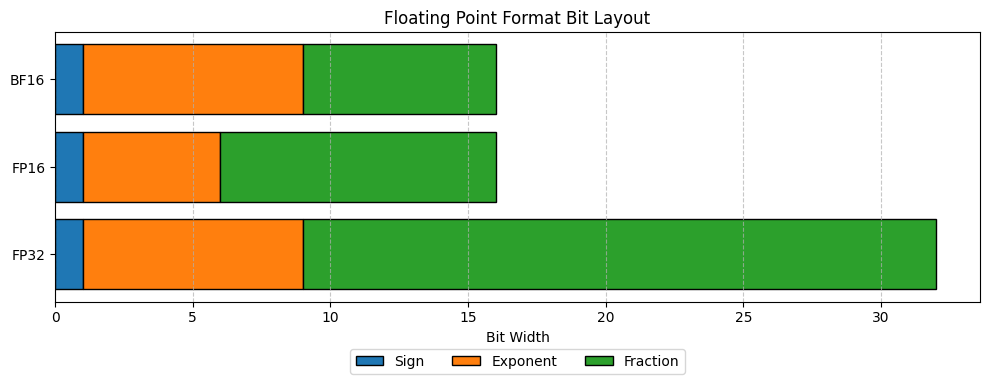

In [5]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['Sign', 'Exponent', 'Fraction']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # consistent colors for each section
bit_sizes = {
    'FP32': [1, 8, 23],
    'FP16': [1, 5, 10],
    'BF16': [1, 8, 7]
}

fig, ax = plt.subplots(figsize=(10, 4))
for i, (key, sizes) in enumerate(bit_sizes.items()):
    left = 0
    for j, size in enumerate(sizes):
        ax.barh(i, size, left=left, color=colors[j], edgecolor='black', label=labels[j] if i == 0 else "")
        left += size

ax.set_yticks(np.arange(len(bit_sizes)))
ax.set_yticklabels(bit_sizes.keys())
ax.set_xlabel('Bit Width')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
ax.set_title("Floating Point Format Bit Layout")
ax.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Downcasting: Cos'è e perché è importante?

**Downcasting** è il processo di conversione dei dati da un formato ad alta precisione a un formato a precisione inferiore, spesso utilizzato nel training per ottimizzare l'uso della memoria e accelerare il calcolo.

#### Vantaggi del Downcasting:
- Riduce l'occupazione di memoria
- Permette di fare training di modelli più grandi o utilizzare batch di dimensioni maggiori
- Può accelerare il calcolo (a seconda dell'hardware)

#### Svantaggi del Downcasting:
- Perdita di precisione numerica
- Rischio di degradare le prestazioni del modello, soprattutto se applicato in modo troppo aggressivo


In [6]:
# Esempio: Downcasting in PyTorch

# Crea un tensore casuale float32
tensor_fp32 = torch.rand(1000, dtype=torch.float32)
print("Tensore originale (float32), primi 5 elementi:", tensor_fp32[:5])

# Converte in bfloat16
tensor_bf16 = tensor_fp32.to(dtype=torch.bfloat16)
print("Tensore downcastato (bfloat16), primi 5 elementi:", tensor_bf16[:5])


Tensore originale (float32), primi 5 elementi: tensor([0.2838, 0.4232, 0.9391, 0.9726, 0.3845])
Tensore downcastato (bfloat16), primi 5 elementi: tensor([0.2832, 0.4238, 0.9375, 0.9727, 0.3848], dtype=torch.bfloat16)


In [7]:
# Confronto della precisione del prodotto scalare

# Calcola il prodotto scalare con float32
m_fp32 = torch.dot(tensor_fp32, tensor_fp32)
print("Prodotto scalare (float32):", m_fp32)

# Calcola il prodotto scalare con bfloat16
tensor_bf16 = tensor_fp32.to(dtype=torch.bfloat16)
m_bf16 = torch.dot(tensor_bf16, tensor_bf16)
print("Prodotto scalare (bfloat16):", m_bf16)


Prodotto scalare (float32): tensor(334.5880)
Prodotto scalare (bfloat16): tensor(334., dtype=torch.bfloat16)


Nota come la precisione ridotta può alterare leggermente i risultati. Nella pratica, i pesi del modello sono memorizzati e aggiornati in piena precisione (`float32`).
